# Interictal MEG abnormalities to guide intracranial electrode implantation and predict surgical outcome 

This notebook can be used to reproduce the figures seen in our paper: Interictal MEG abnormalities to guide intracranial electrode implantation and predict surgical outcome.

The code has been stripped back to omit any PID but contains the minimal amount of data required to recreate the main results

## Section 1: Load in the packages, functions and data

In [23]:
from project_functions import *
import warnings
warnings.filterwarnings('ignore')

In [24]:
with open('../data/patient_data.pkl', 'rb') as f:
    patient_data = pickle.load(f)

## Replicate the analysis from the paper

In [25]:
#create a folder to save the files
path='../data/'

if not os.path.exists(path):

    os.makedirs(path) 

#Set a resection threshold. This is for the MEG data. Any proportion of volume change greater than this will be classified as resected
threshold=0.1

#create an empty list to store the patient results
patient_results=[]

#for every subject...
for subject in patient_data.keys():

    #compute the maximum absolute z-scores for each region
    meg_maximum_abnormalities=np.max(np.abs(patient_data[subject]['meg_zscores'][:,:]),axis=1)
    eeg_maximum_abnormalities=np.max(np.abs(patient_data[subject]['eeg_zscores'][:,:]),axis=1)

    #create a binary 128x1 array showing where eeg electrodes were implanted
    eeg_coverage=copy.copy(eeg_maximum_abnormalities)
    eeg_coverage[eeg_coverage>0]=1
    eeg_coverage[np.isnan(eeg_coverage)]=0

    #load in the overlap data corresponding to the pre and post operative volume change.
    #Binarise the array based on the selected threshold value
    overlaps=np.array([1 if x>threshold else 0 for x in patient_data[subject]['region_resection_prop']])

    #For iEEG we use the same definition in Taylor et al. 2022 (If 10% of electrodes in each region are removed then class as resected)
    electrode_resection=patient_data[subject]['electrode_contact_resection']

    #Compute the abnormality coverage measure using cortical regions only
    meeg_concordance=roc_auc_score(eeg_coverage[14:],meg_maximum_abnormalities[14:])

    #merge the data together
    example_patient_data=pd.DataFrame({'eeg_abnormality':eeg_maximum_abnormalities,
                    'meg_abnormality':meg_maximum_abnormalities,
                    'resection':overlaps,
                    'electrode_resection':electrode_resection})

    #Filter only those regions where electrodes were implanted
    example_patient_data = example_patient_data[example_patient_data['eeg_abnormality'].notna()]

    #Compute the iEEG DRS
    eeg_drs=1-roc_auc_score(example_patient_data['electrode_resection'],example_patient_data['eeg_abnormality'])

    #Combine the data for the MEG data
    example_patient_data=pd.DataFrame({'eeg_abnormality':eeg_maximum_abnormalities,
                        'meg_abnormality':meg_maximum_abnormalities,
                        'resection':overlaps})

    #filter out the subcortical regions
    example_patient_data = example_patient_data.iloc[14:,]

    #retain only regions where there is also iEEG coverage
    example_patient_data = example_patient_data[example_patient_data['eeg_abnormality'].notna()]

    #compute the MEG DRS
    meg_drs=1-roc_auc_score(example_patient_data['resection'],example_patient_data['meg_abnormality'])

    outcome=patient_data[subject]['outcome']

    #store the patient results
    patient_results.append([subject,meeg_concordance,eeg_drs,meg_drs,outcome])


#Combine all the data into a single object
patient_results=pd.DataFrame(patient_results,columns=['ID','electrode_concordance','eeg_drs','meg_drs_electrode_coverage','outcome'])

#save as a csv
patient_results[['ID', 'outcome', 'electrode_concordance', 'meg_drs_electrode_coverage',
                    'eeg_drs']].to_csv('../data/nomogram_data.csv', index=False)

#Run the R script that combines the measures and creates a nomogram
subprocess.call(['Rscript','--vanilla',"../R/plotNomogram_robust.R"])

#load in the output from the R script
nomogram_data=pd.read_csv('../data/nomogram_predict_full.csv')

Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits


null device 
          1 


Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Sett

In [26]:
print('Abnormality Coverage AUC:',1- roc_auc_score(nomogram_data['outcome'],nomogram_data['electrode_concordance']))
print('EEG DRS AUC:',roc_auc_score(nomogram_data['outcome'],nomogram_data['eeg_drs']))
print('MEG DRS AUC:',roc_auc_score(nomogram_data['outcome'],nomogram_data['meg_drs_electrode_coverage']))
print('Nomogram AUC:',1-roc_auc_score(nomogram_data['outcome'],nomogram_data['pts']))

Abnormality Coverage AUC: 0.6833333333333333
EEG DRS AUC: 0.7374999999999999
MEG DRS AUC: 0.7104166666666667
Nomogram AUC: 0.7958333333333333


## Code to reproduce Figure 2

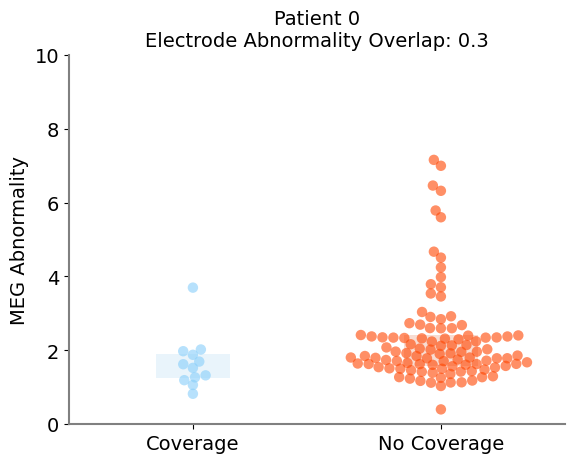

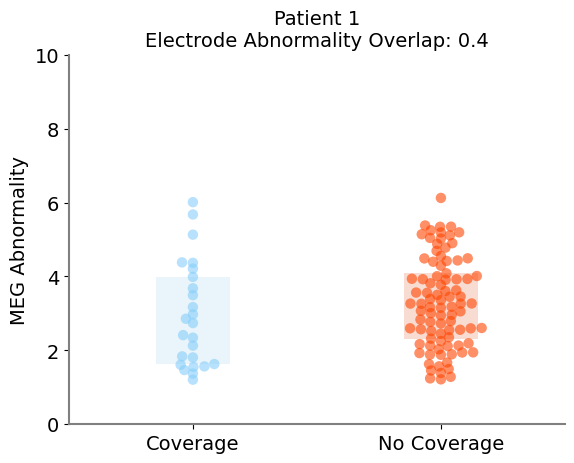

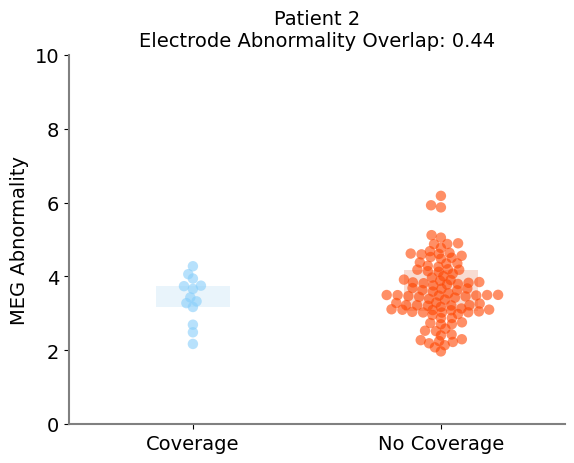

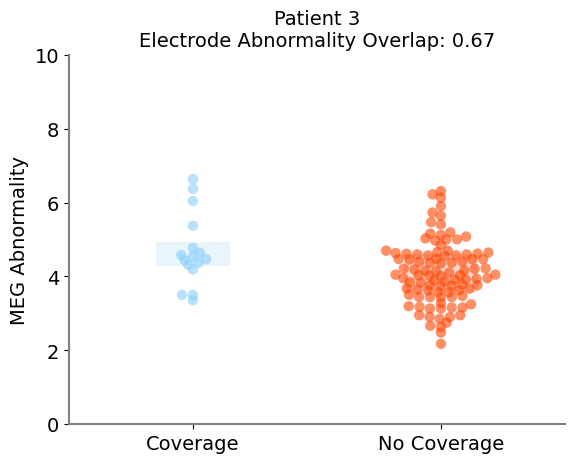

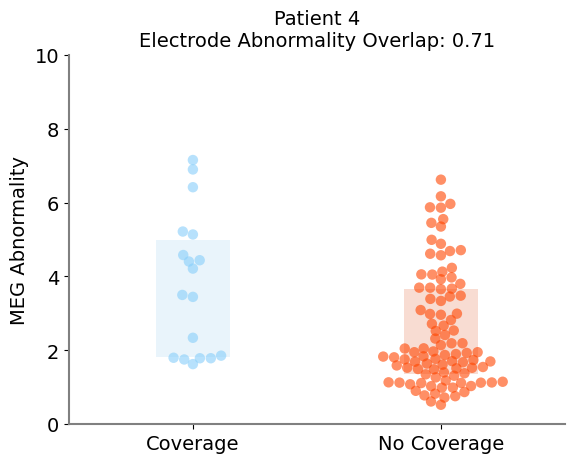

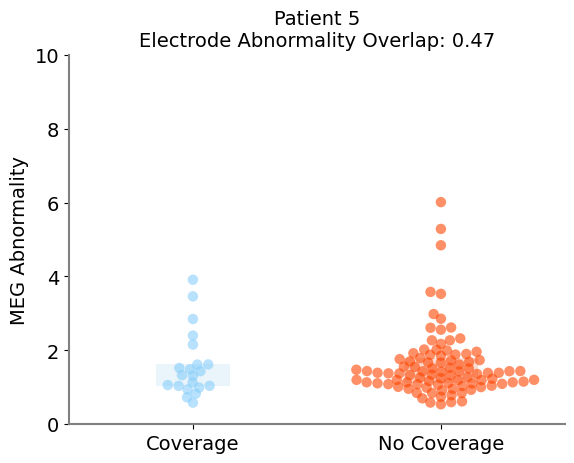

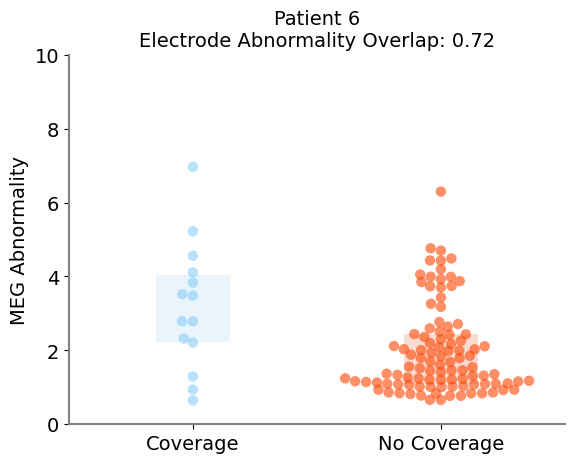

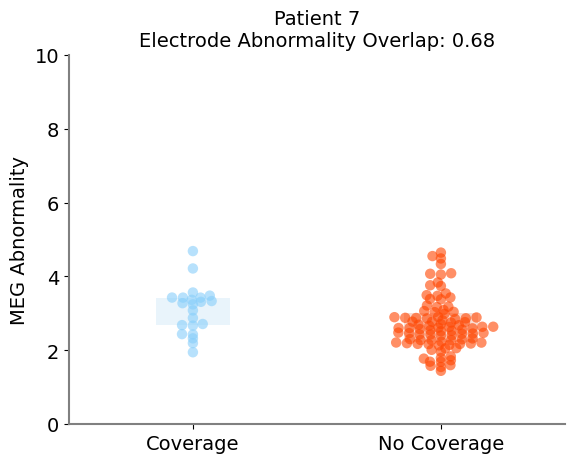

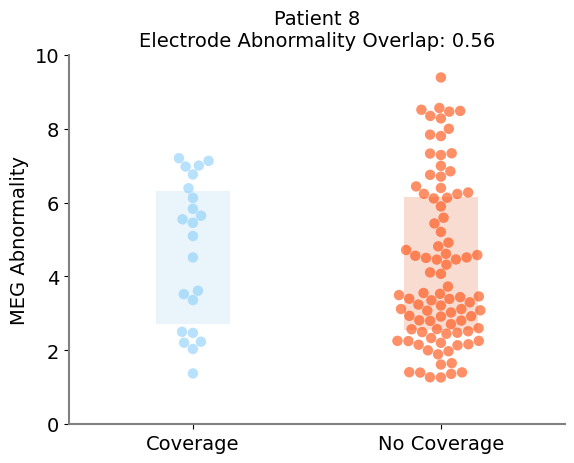

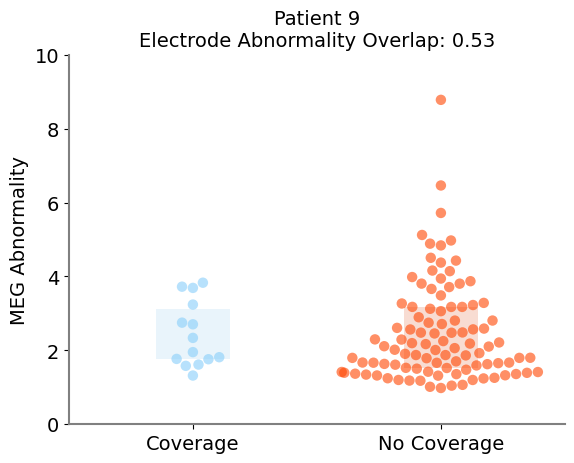

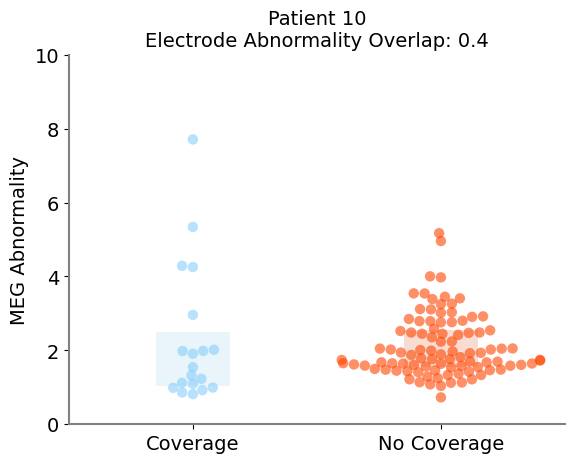

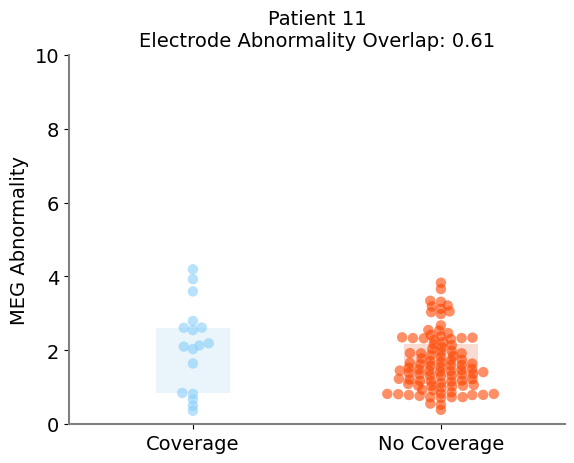

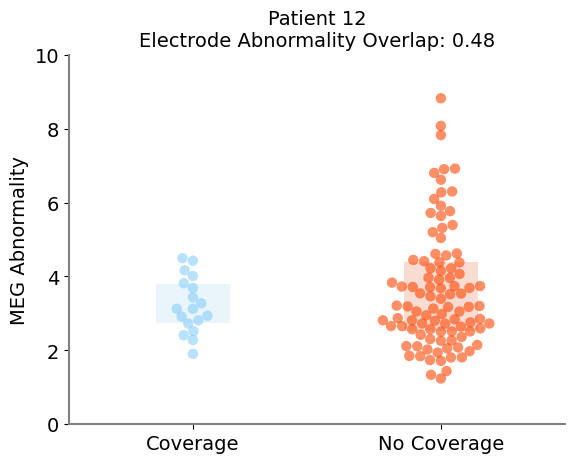

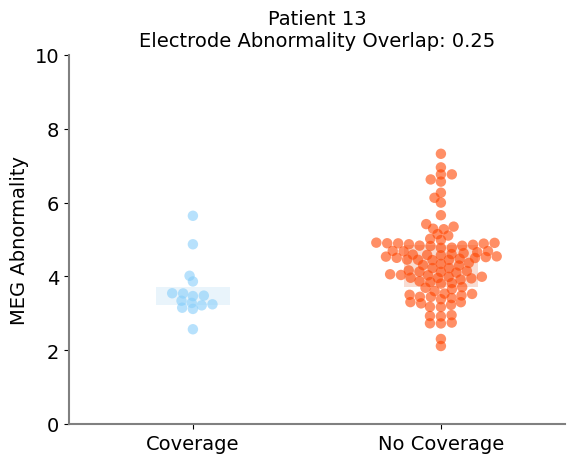

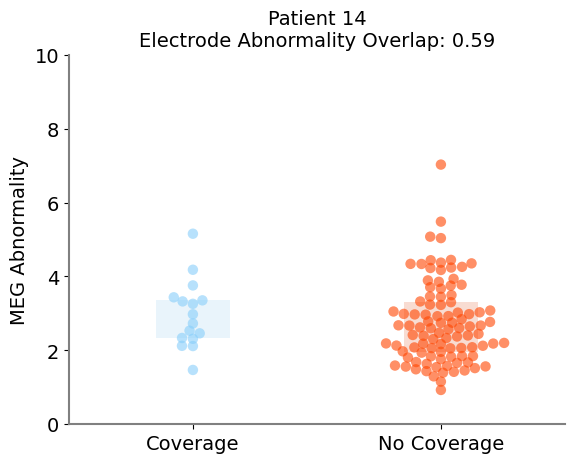

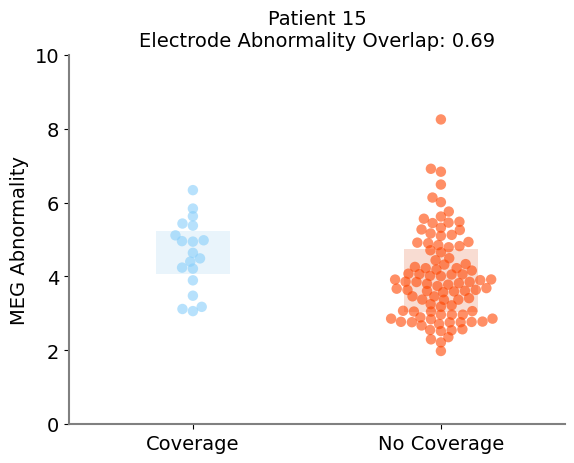

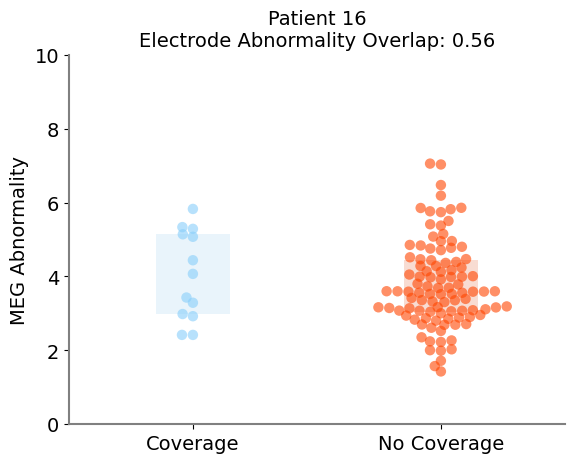

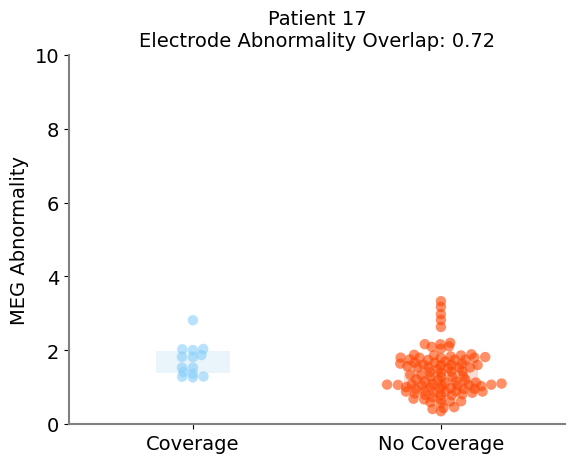

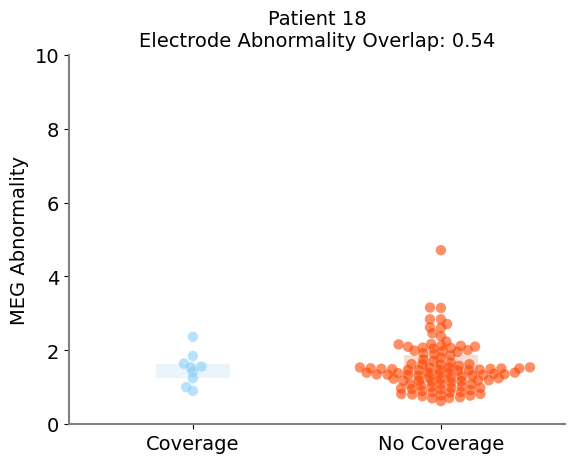

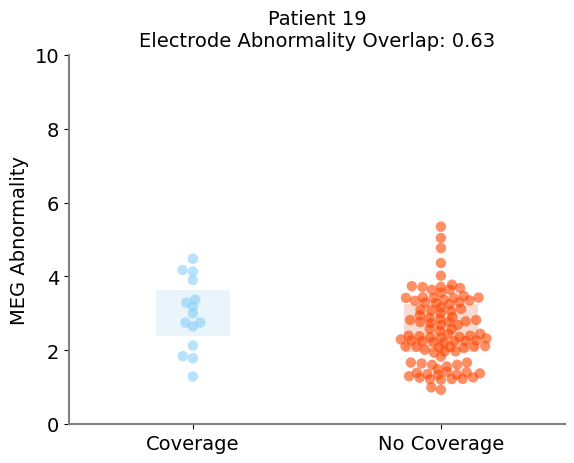

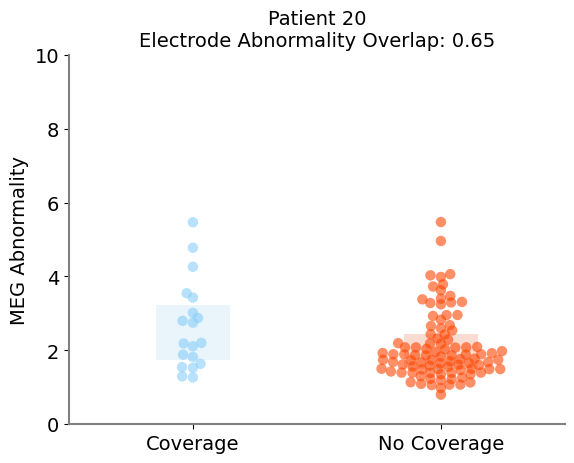

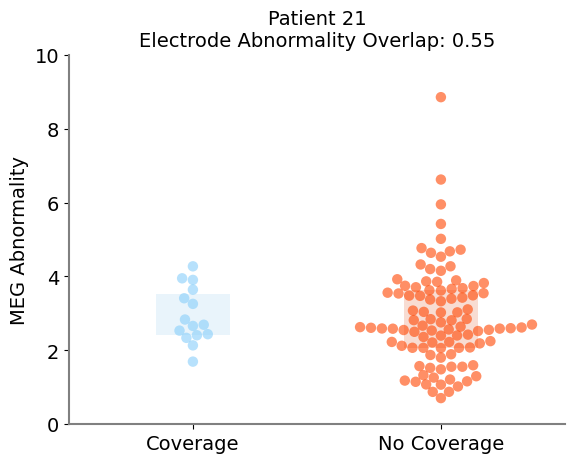

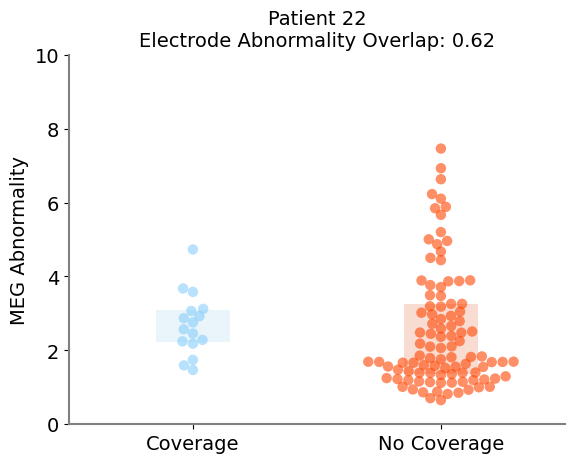

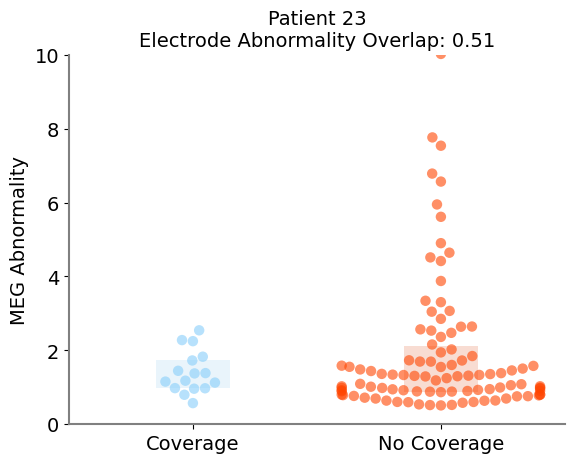

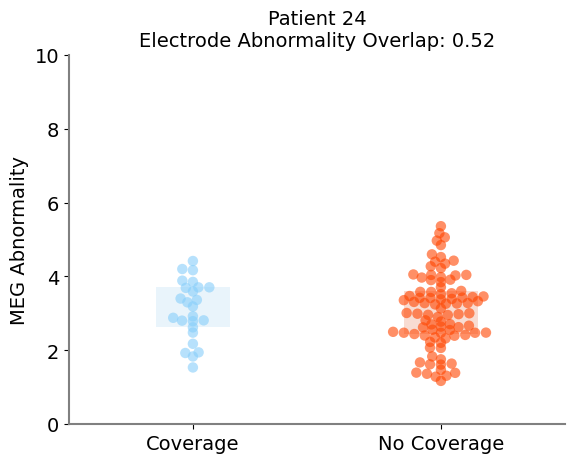

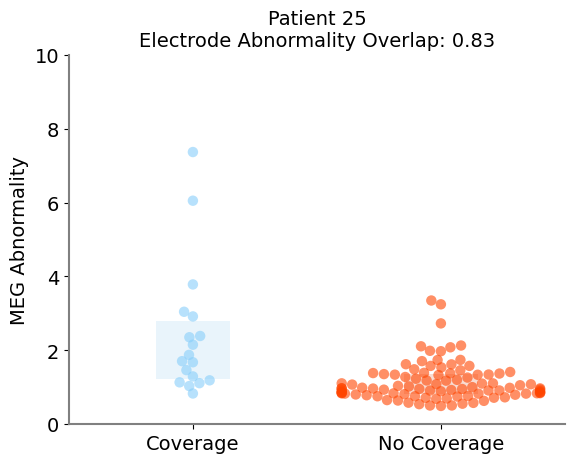

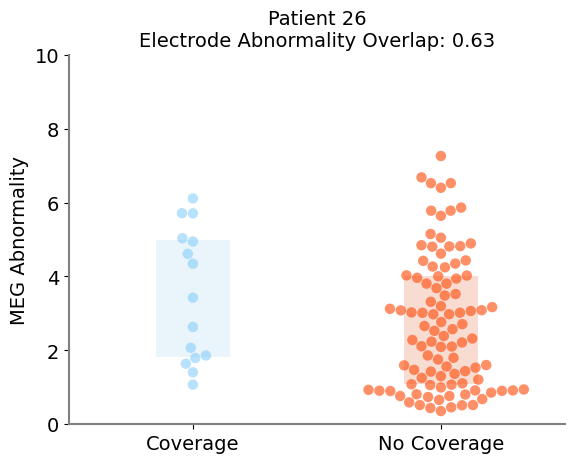

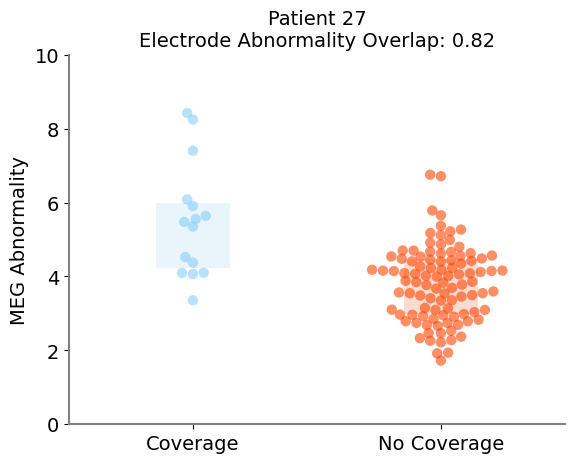

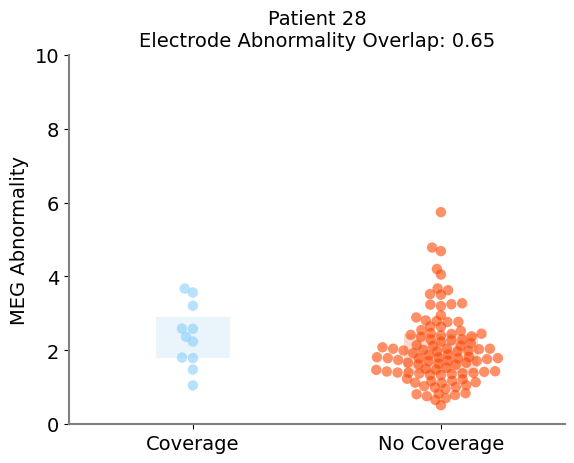

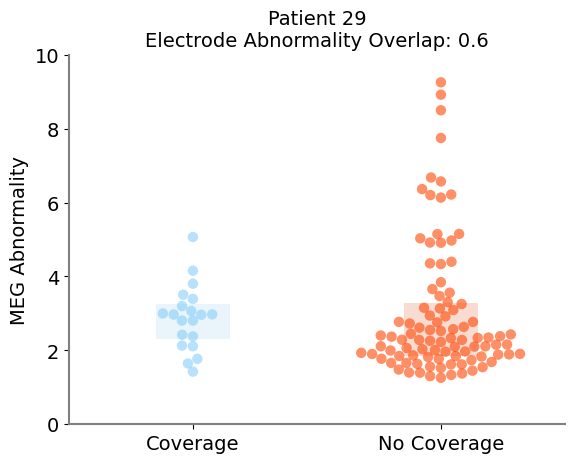

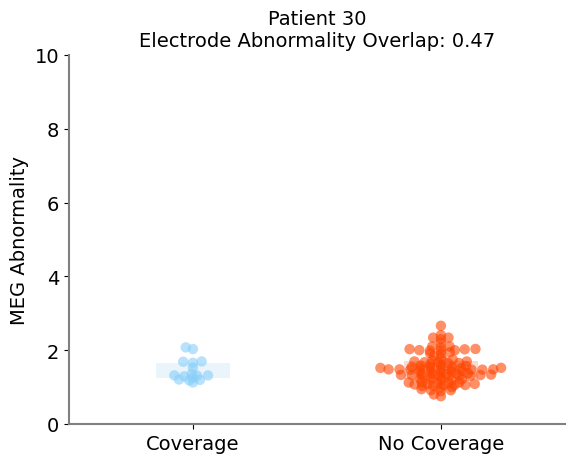

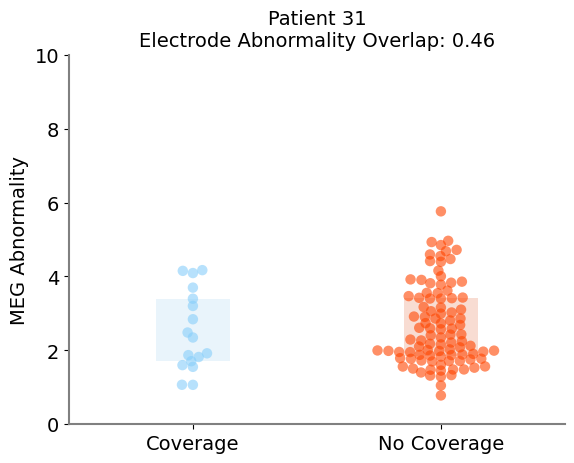

In [27]:
#create a folder to save the files
path='../figures/figure2/'

if not os.path.exists(path):

    os.makedirs(path) 


#for every subject plot the concordance and save
for idx,subject in enumerate(patient_data.keys()):

    #create a temporary dataframe with the patients MEG and EEG data
    meg_maximum_abnormalities=np.max(np.abs(patient_data[subject]['meg_zscores'][:,:]),axis=1)
    eeg_maximum_abnormalities=np.max(np.abs(patient_data[subject]['eeg_zscores'][:,:]),axis=1)

    eeg_coverage=copy.copy(eeg_maximum_abnormalities)
    eeg_coverage[eeg_coverage>0]=1
    eeg_coverage[np.isnan(eeg_coverage)]=0

    example_patient_data=pd.DataFrame({'eeg_abnormality':eeg_maximum_abnormalities,
                            'meg_abnormality':meg_maximum_abnormalities,
                            'eeg_coverage':eeg_coverage})

    example_patient_data = example_patient_data.iloc[14:,]

   
    example_patient_data['Coverage']=['Coverage' if x==1 else 'No Coverage' for x in example_patient_data['eeg_coverage']]
    

    #compute the AUC for the abnormality coverage
    AUC=1-roc_auc_score(example_patient_data['Coverage'],example_patient_data['meg_abnormality'])

    #Plot the data using the custom plotting function
    plot_concordance(example_patient_data,'Coverage','meg_abnormality','MEG Abnormality',[0,10],'Patient ' +str(idx)+'\nElectrode Abnormality Overlap: '+str(round(AUC,2)))

    plt.savefig(path+'patient_'+str(idx)+'_electrode_overlap.pdf',transparent=True)
    plt.show()



## Code to reproduce Figure 3

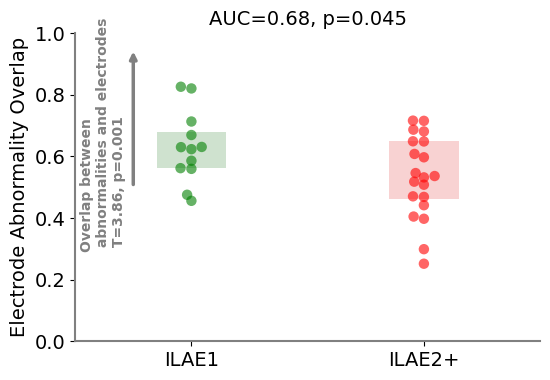

In [11]:
#create a folder to save the files
path='../figures/figure3/'

if not os.path.exists(path):

    os.makedirs(path) 
    
#compute the AUC, p value and ILAE 1 t-test statistics
AUC=1-roc_auc_score(nomogram_data['outcome'],nomogram_data['electrode_concordance'])

#Compute the corresponding p-value
U,P=stats.mannwhitneyu(nomogram_data[nomogram_data['outcome']=='ILAE1']['electrode_concordance'],
                       nomogram_data[nomogram_data['outcome']=='ILAE2+']['electrode_concordance'],alternative='greater')

#Compute the t-statistic
T,p_value=stats.ttest_1samp(nomogram_data[nomogram_data['outcome']=='ILAE1']['electrode_concordance'], popmean=0.5)

#plot the results
nrow=1
ncol=1

fig = plt.figure(figsize=(6,4))

fig.add_subplot(nrow,ncol,1)


plot_AUC(nomogram_data,'outcome','electrode_concordance','Electrode Abnormality Overlap',[0,1],'AUC='+str(round(AUC,2))+', p='+str(round(P,3)))

plt.annotate("",
            xy=(-0.25, 0.95),
            xytext=(-0.25, 0.5), 
            va="center",
            ha="center",
            arrowprops={"arrowstyle": "-|>", "lw": 2.5,"color":'grey'})

plt.text(-0.48, 0.3, "Overlap between \n abnormalities and electrodes \n T="+str(round(T,2))+", p=" +str(round(p_value/2,3)), horizontalalignment='left', size='medium', color='grey', weight='semibold',rotation=90)

plt.savefig(path+'cohort_outcome_results.pdf',transparent=True)

## Code to reproduce Figure 4

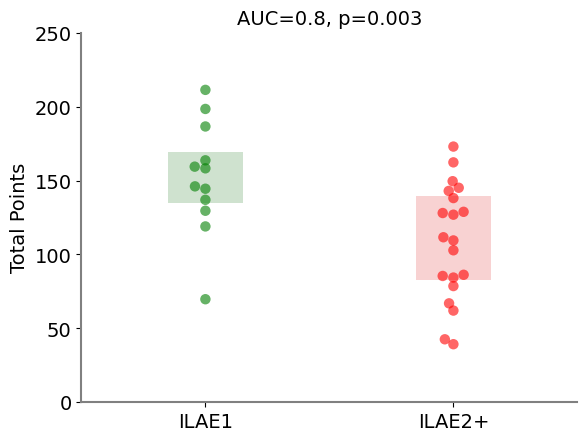

In [12]:
path='../figures/figure4/'

if not os.path.exists(path):

    os.makedirs(path) 

AUC=1-roc_auc_score(nomogram_data['outcome'],nomogram_data['pts'])

U,P=stats.mannwhitneyu(nomogram_data[nomogram_data['outcome']=='ILAE1']['pts'],
                        nomogram_data[nomogram_data['outcome']=='ILAE2+']['pts'],alternative='greater')


#plot the results for the Nomogram data
plot_AUC(nomogram_data,'outcome','pts','Total Points',[0,250],'AUC='+str(round(AUC,2))+', p='+str(round(P,3)))



plt.savefig(path+'nomogram_points_boxplot.pdf',transparent=True)


### Plot the ROC curve

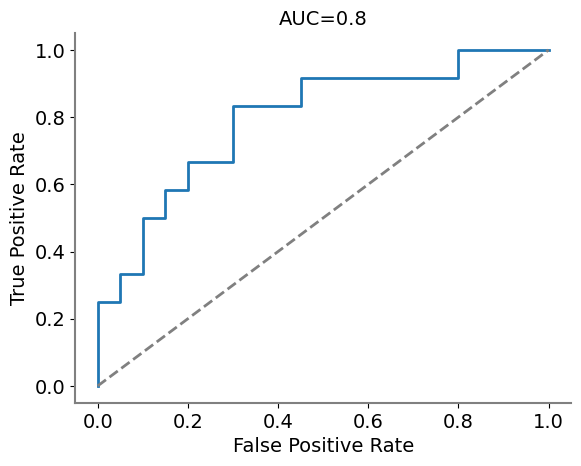

In [13]:
fpr, tpr, thresholds = roc_curve(nomogram_data['outcome'], nomogram_data['pts'],pos_label='ILAE1')


ax=plt.plot(fpr,tpr,linewidth=2)


plt.plot([0,1],[0,1],'--',color='grey',linewidth=2)
plt.xlabel('False Positive Rate',size=14)
plt.ylabel('True Positive Rate',size=14) 
plt.xticks(size=14)
plt.yticks(size=14)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().spines['left'].set_edgecolor('grey')
plt.gca().spines['bottom'].set_edgecolor('grey')
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

AUC=1-roc_auc_score(nomogram_data['outcome'],nomogram_data['pts'])


plt.title('AUC='+str(round(AUC,2)),size=14)
plt.savefig(path+'nomogram_roc_curve.pdf',transparent=True)

## Code to reproduce figure S1

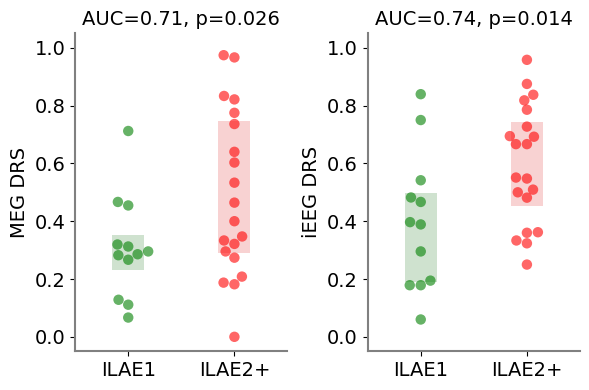

In [14]:
path='../figures/figureS1/'

if not os.path.exists(path):

    os.makedirs(path) 


nrow=1
ncol=2

fig = plt.figure(figsize=(6,4))

fig.add_subplot(nrow,ncol,1)

AUC=roc_auc_score(nomogram_data['outcome'],nomogram_data['meg_drs_electrode_coverage'])

U,P=stats.mannwhitneyu(nomogram_data[nomogram_data['outcome']=='ILAE1']['meg_drs_electrode_coverage'],
                        nomogram_data[nomogram_data['outcome']=='ILAE2+']['meg_drs_electrode_coverage'],alternative='less')


#plot the results for the MEG data
plot_AUC(nomogram_data,'outcome','meg_drs_electrode_coverage','MEG DRS',[-0.05,1.05],'AUC='+str(round(AUC,2))+', p='+str(round(P,3)))


fig.add_subplot(nrow,ncol,2)

AUC=roc_auc_score(nomogram_data['outcome'],nomogram_data['eeg_drs'])

U,P=stats.mannwhitneyu(nomogram_data[nomogram_data['outcome']=='ILAE1']['eeg_drs'],
                       nomogram_data[nomogram_data['outcome']=='ILAE2+']['eeg_drs'],alternative='less')


#plot the results for the iEEG data
plot_AUC(nomogram_data,'outcome','eeg_drs','iEEG DRS',[-0.05,1.05],'AUC='+str(round(AUC,2))+', p='+str(round(P,3)))

fig.tight_layout()


plt.savefig(path+'DRS_results.pdf',transparent=True)

## Supplementary analysis: Scanning the resection threshold

**Note**: In this analysis both MEG and iEEG have the same definition of resected. That is if the pre and post-operative volume change of a region exceeds a threshold then it is classified as resected

In [16]:
threshold_scanning_results=[]


for threshold in [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,
                  0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,
                  0.21,0.22,0.23,0.24,0.25]:

    print('Starting threshold: '+str(threshold))

    patient_results=[]

    for subject in patient_data.keys():

        meg_maximum_abnormalities=np.max(np.abs(patient_data[subject]['meg_zscores'][:,:]),axis=1)
        eeg_maximum_abnormalities=np.max(np.abs(patient_data[subject]['eeg_zscores'][:,:]),axis=1)

        eeg_coverage=copy.copy(eeg_maximum_abnormalities)
        eeg_coverage[eeg_coverage>0]=1
        eeg_coverage[np.isnan(eeg_coverage)]=0

        overlaps=np.array([1 if x>threshold else 0 for x in patient_data[subject]['region_resection_prop']])


        meeg_concordance=roc_auc_score(eeg_coverage[14:],meg_maximum_abnormalities[14:])

        example_patient_data=pd.DataFrame({'eeg_abnormality':eeg_maximum_abnormalities,
                        'meg_abnormality':meg_maximum_abnormalities,
                        'resection':overlaps})

        example_patient_data = example_patient_data[example_patient_data['eeg_abnormality'].notna()]

        eeg_drs=1-roc_auc_score(example_patient_data['resection'],example_patient_data['eeg_abnormality'])


        example_patient_data=pd.DataFrame({'eeg_abnormality':eeg_maximum_abnormalities,
                            'meg_abnormality':meg_maximum_abnormalities,
                            'resection':overlaps})

        example_patient_data = example_patient_data.iloc[14:,]

        example_patient_data = example_patient_data[example_patient_data['eeg_abnormality'].notna()]

        meg_drs=1-roc_auc_score(example_patient_data['resection'],example_patient_data['meg_abnormality'])

        outcome=patient_data[subject]['outcome']

        patient_results.append([subject,meeg_concordance,eeg_drs,meg_drs,outcome])


    results=pd.DataFrame(patient_results,columns=['ID','electrode_concordance','eeg_drs','meg_drs_electrode_coverage','outcome'])

    results[['ID', 'outcome', 'electrode_concordance', 'meg_drs_electrode_coverage',
                        'eeg_drs']].to_csv('../data/nomogram_data.csv', index=False)

    subprocess.call(['Rscript','--vanilla',"../R/plotNomogram_robust.R"])

    #load in the output from the R script
    nomogram=pd.read_csv('../data/nomogram_predict_full.csv')

    nomo_auc=1-roc_auc_score(nomogram['outcome'],nomogram['pts'])

    meg_auc=roc_auc_score(nomogram['outcome'],nomogram['meg_drs_electrode_coverage'])

    eeg_auc=roc_auc_score(nomogram['outcome'],nomogram['eeg_drs'])

    concordance_auc=1-roc_auc_score(nomogram['outcome'],nomogram['electrode_concordance'])

    threshold_scanning_results.append([threshold,concordance_auc,eeg_auc,meg_auc,nomo_auc])

Starting threshold: 0


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.01


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.02


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.03


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.04


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.05


Error: unexpected symbol in:
"    
    retur    return"
Execution halted


Starting threshold: 0.06


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.07


Error: unexpected 'else' in:
"    #lp
  }else"
Execution halted


Starting threshold: 0.08


Error: unexpected input in:
"      }
      score=_"
Execution halted


Starting threshold: 0.09


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.1


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.11


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.12


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.13


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.14


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.15


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.16


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.17


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.18


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.19


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.2


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.21


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.22


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.23


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.24


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

Starting threshold: 0.25


Warning message:
In lrm(outcome ~ EPC + MEG_DRS + EEG_DRS + 0, data = patient_metrics_subset,  :
  currently weights are ignored in model validation and bootstrapping lrm fits
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < cases
Setting levels: control = ILAE2+, case = ILAE1
Setting direction: controls < 

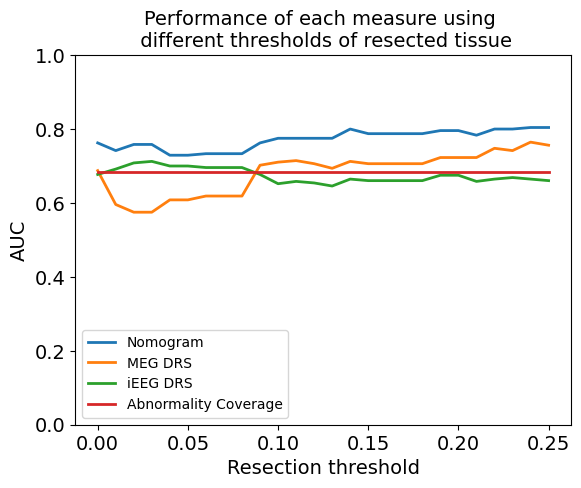

In [22]:
#Convert the results to a dataframe
threshold_scanning_results=pd.DataFrame(threshold_scanning_results,columns=['threshold','concordance','eeg','meg','nomogram'])


path='../figures/Supplementary_plots/'

if not os.path.exists(path):

    os.makedirs(path) 
    
#Plot lines to see the performance of the model using different thresholds
sns.lineplot(data=threshold_scanning_results,x='threshold',y='nomogram',linewidth=2)
sns.lineplot(data=threshold_scanning_results,x='threshold',y='meg',linewidth=2)
sns.lineplot(data=threshold_scanning_results,x='threshold',y='eeg',linewidth=2)
sns.lineplot(data=threshold_scanning_results,x='threshold',y='concordance',linewidth=2)
plt.xlabel('Resection threshold',size=14)
plt.ylabel('AUC',size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Performance of each measure using \n different thresholds of resected tissue',size=14)
plt.ylim([0,1])


plt.legend(['Nomogram', 'MEG DRS', 'iEEG DRS','Abnormality Coverage'])
plt.savefig(path+'changing_threshold.pdf',transparent=True,dpi=600 )